The `rfcde` package can be installed directly by cloning the Github repository:

<code style="background:black;color:white">git clone https://github.com/tpospisi/RFCDE.git </code> <br>
<code style="background:black;color:white">cd RFCDE/python/ </code> <br>
<code style="background:black;color:white">python setup.py install </code> 

WARNING: the installation might fail on the newest MAC OS. This is a known issue: look at the "Troubleshooting" section in the [README repository](https://github.com/tpospisi/RFCDE).

In [1]:
import numpy as np
import rfcde
from cdetools.cde_loss import cde_loss
from matplotlib import pyplot as plt

In the following cell we run the `wget` module to fetch the data from the [COINtoolbox Github repository](https://github.com/COINtoolbox/photoz_catalogues/tree/master/Teddy). <br>
You can download the Teddy A and B manually if you prefer.

In [2]:
import os
import wget

data_dir = 'data/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print('"data" subfolder created')
    
_ = wget.download('https://github.com/COINtoolbox/photoz_catalogues/raw/master/Teddy/teddy_A', 
              out='data/teddy_A.txt')

_ = wget.download('https://github.com/COINtoolbox/photoz_catalogues/raw/master/Teddy/teddy_B', 
              out='data/teddy_B.txt')

The following lines assume you have the datasets `Teddy A` and `Teddy B` in a subfolder of your current directory. By default this subfolder is `data`, but it can be changed below. The following function extract the information from the .txt file and generates numpy array. <br> <br>

You can find the `Teddy A` and `Teddy B` dataset in the [COINtoolbox Github repository](https://github.com/COINtoolbox/photoz_catalogues/tree/master/Teddy).

In [3]:
def extract_teddy_data(filename, train_data, directory='data/'):
    
    full_data = []
    outfiles = ('teddy_x_train.npy', 'teddy_z_train.npy') if train_data else ('teddy_x_test.npy', 'teddy_z_test.npy')
    with open(filename) as fp:
        full_lines = fp.readlines()
        for line in full_lines:
            if '#' in line:
                continue
            full_data.append([float(el) for el in line.strip().split(' ') if el])
        fp.close()
    
    # Saving the formatted Teddy data
    np.save(arr=np.array(full_data)[:, 7:12], file=directory + outfiles[0])
    np.save(arr=np.array(full_data)[:, 6], file=directory + outfiles[1])
    print('Extraction and Saving Done!')

In [4]:
extract_teddy_data(filename='data/teddy_A.txt', train_data=True, directory='data/')

Extraction and Saving Done!


In [5]:
extract_teddy_data(filename='data/teddy_B.txt', train_data=False, directory='data/')

Extraction and Saving Done!


## Load Teddy Cosmology Data

The $\texttt{TEDDY}$ data are comprised of 4 datasets, generated by subsampling from the [SDSS DR12](https://www.sdss.org/dr12/). <br>
The 4 datasets are named respectively A, B, C and D.

We use dataset A for training and B for testing.<br>
Data in these two datasets share the same underlying distribution, so training-based algorithms do not need any further adjustments. <br>
For more information, consult the [TEDDY Github Repo](https://github.com/COINtoolbox/photoz_catalogues/tree/master/Teddy).

Both datasets have around 74,000 spectroscopic samples in it. <br>
We downsample both training and testing, including only the first 2,000 and 500 galaxies respectively.

In [6]:
train_limit_points = 2000    # Limiting the training set
test_limit_points = 500      # Limiting the test set
x_train = np.load(file='data/teddy_x_train.npy')[:train_limit_points, :]
x_test = np.load(file='data/teddy_x_test.npy')[:test_limit_points, :]
z_train = np.load(file='data/teddy_y_train.npy')[:train_limit_points]
z_test = np.load(file='data/teddy_y_test.npy')[:test_limit_points]

## Running RFCDE

As any $\texttt{sklearn}$ model, with the first call we initialize the model. <br>
We need to specify the following:
* random forest hyper-parameters; here we include:
    - the number of trees `n_trees`, 
    - the number of variables to evaluate at each split `mtry` and 
    - the minimum number of observations in each node `node_size`.
* at each tree, the split is done by optimizing the CDE loss. For fast computation, the CDE loss is calculated by assuming the conditional density estimate can be written as a basis expansion. `n_basis` governs the number of basis used for this calculation, and `basis_system` selects the basis system.

In [7]:
n_trees = 100
mtry = 4
node_size = 20

n_basis = 30
basis_system = 'cosine'

model = rfcde.RFCDE(n_trees=n_trees, mtry=mtry, node_size=node_size, n_basis=n_basis, 
                    basis_system=basis_system)

We then train the model by using the `train` method

In [8]:
%%time

model.train(x_train, z_train)

CPU times: user 610 ms, sys: 27.8 ms, total: 638 ms
Wall time: 1.02 s


For prediction, we need to specify:
* the CDE support, i.e. the grid over which we want the CDE to be predicted. Here we use the training data to inform the redshift minimum and maximum, and generate `n_grid` linearly separated values between the two.
* the bandwith of the KDE with `bandwidth`

In [9]:
%%time

n_grid = 1000
bandwidth = 0.01
z_grid = np.linspace(z_train.min(), z_train.max(), n_grid)
cde_test = model.predict(x_test, z_grid, bandwidth=bandwidth)

CPU times: user 6.05 s, sys: 933 ms, total: 6.98 s
Wall time: 5.08 s


The output CDEs are `n_grid` dimensional densities, stored  in a numpy array. <br>
They are proper density, i.e. they integrate to 1.

In [10]:
from scipy.integrate import simps

print(type(cde_test), cde_test.shape)

den_integral = simps(cde_test[0, :], x=z_grid)
print('Integral of the first density integrates to: %.2f' % den_integral)

<class 'numpy.ndarray'> (500, 1000)
Integral of the first density integrates to: 1.00


### Visualize Predicted CDEs

We can calculate the CDE loss function importing the function from the [`cdetools` package](https://github.com/tpospisi/cdetools).

In [11]:
cde_loss_val, std_cde_loss = cde_loss(cde_test, z_grid, z_test)
print('CDE Loss: %4.2f \pm %.2f' % (cde_loss_val, std_cde_loss))

CDE Loss: -12.48 \pm 0.51


We here visualize the first 12 CDEs

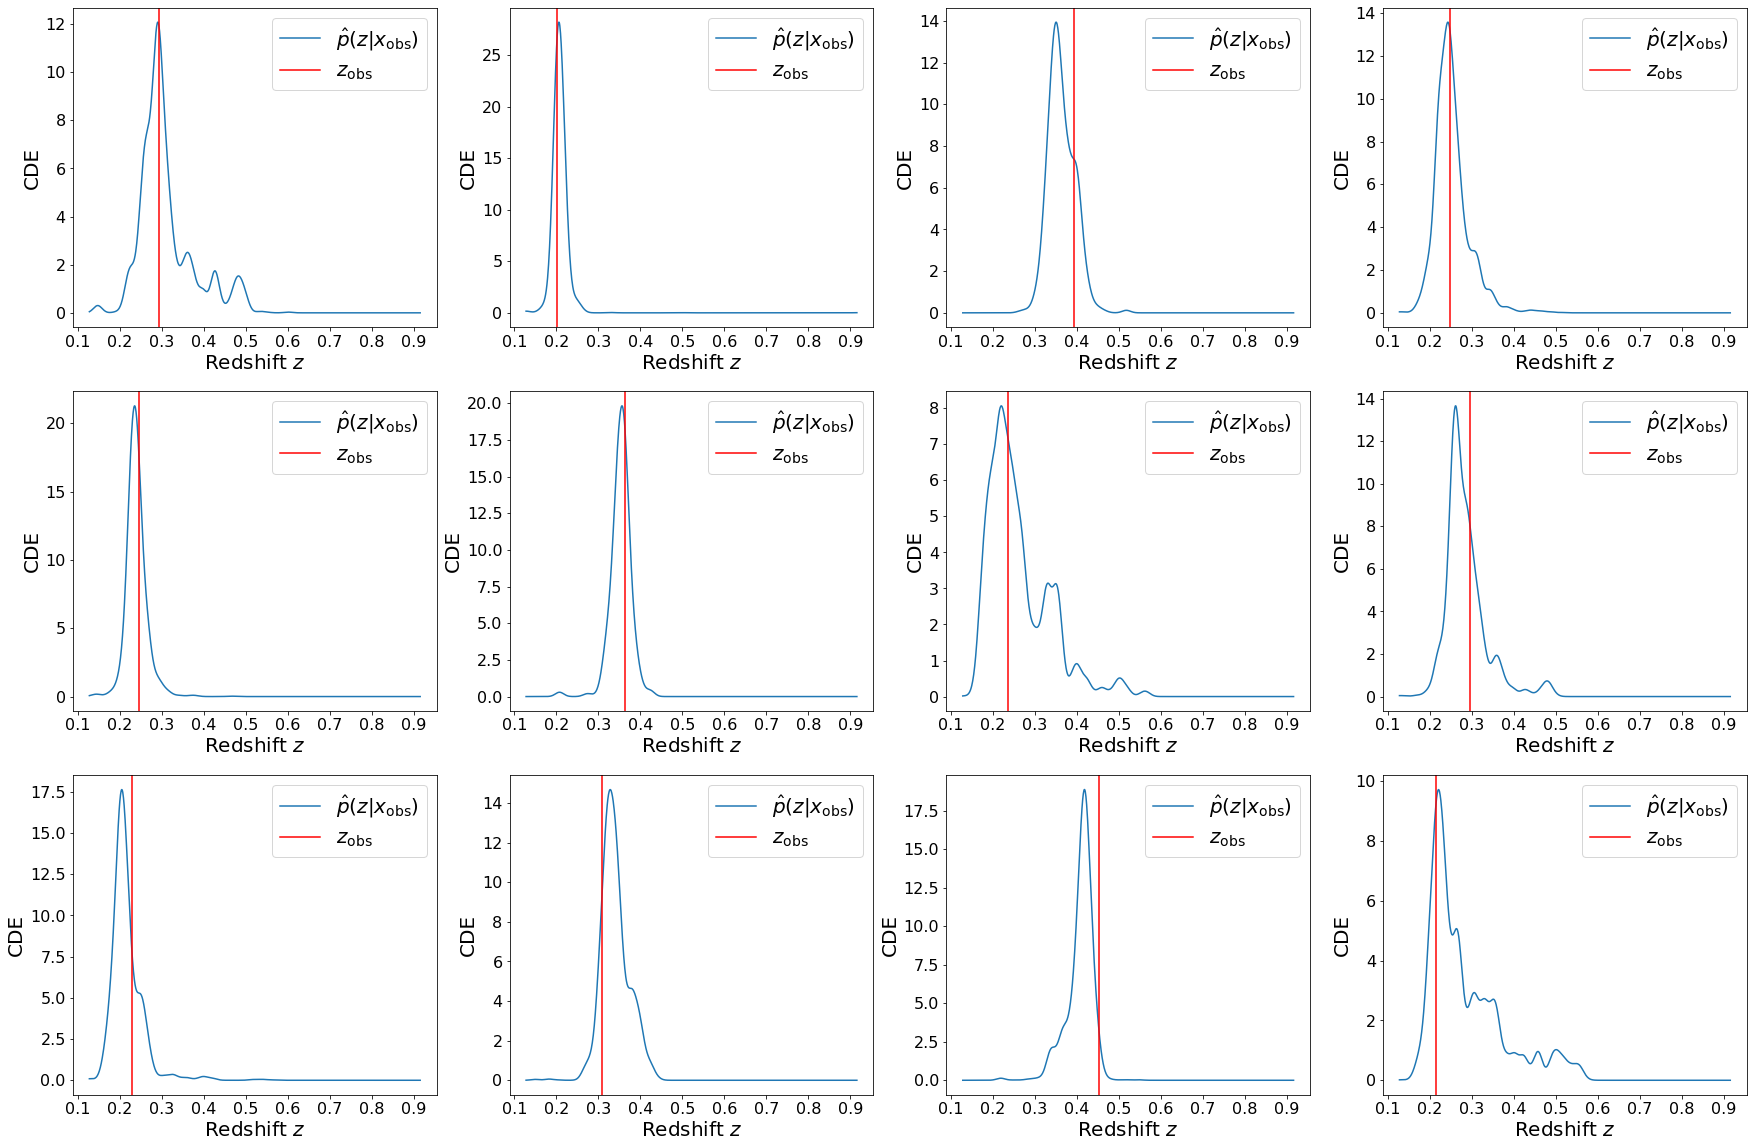

In [12]:
fig = plt.figure(figsize=(30, 20))
for jj, cde_predicted in enumerate(cde_test[:12,:]):
    ax = fig.add_subplot(3, 4, jj + 1)
    plt.plot(z_grid, cde_predicted, label=r'$\hat{p}(z| x_{\rm obs})$')
    plt.axvline(z_test[jj], color='red', label=r'$z_{\rm obs}$')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel(r'Redshift $z$', size=20)
    plt.ylabel('CDE', size=20)
    plt.legend(loc='upper right', prop={'size': 20})
plt.show()

### Hyperparameter Optimization

If one wants to optimize the random forest hyperparameters, the method needs to go through re-training. <br>
However, if one wants to optimize the KDE bandwidth only, this can be done without re-training. <br>
Here we show a simple search, but one can use random search or more advanced methods such as [Bayesian Optimization](https://github.com/fmfn/BayesianOptimization).

In [13]:
for h in [1e-2, 5e-2, 0.1, 0.5]:
    cde_test_temp = model.predict(x_test, z_grid, bandwidth=h)
    cde_loss_temp, std_loss_temp = cde_loss(cde_test_temp, z_grid, z_test)
    message_out = r'Bandwith: %.3f, CDE loss: %4.2f \pm %.2f' % (
        h, cde_loss_temp, std_loss_temp)
    print(message_out)

Bandwith: 0.010, CDE loss: -12.48 \pm 0.51
Bandwith: 0.050, CDE loss: -7.73 \pm 0.10
Bandwith: 0.100, CDE loss: -4.73 \pm 0.03
Bandwith: 0.500, CDE loss: -1.22 \pm 0.00


###  Conditional means, Conditional quantiles and Variable Importance

We can calculate conditional means, as well as any conditional quantiles from the trained `RFCDE` model directly. <br>
Here we show the values for the first 12 CDEs.

In [14]:
cond_mean = model.predict_mean(x_test)
cond_median = model.predict_quantile(x_test, 0.5)
cond_mode = z_grid[np.argmax(cde_test, axis=1)]

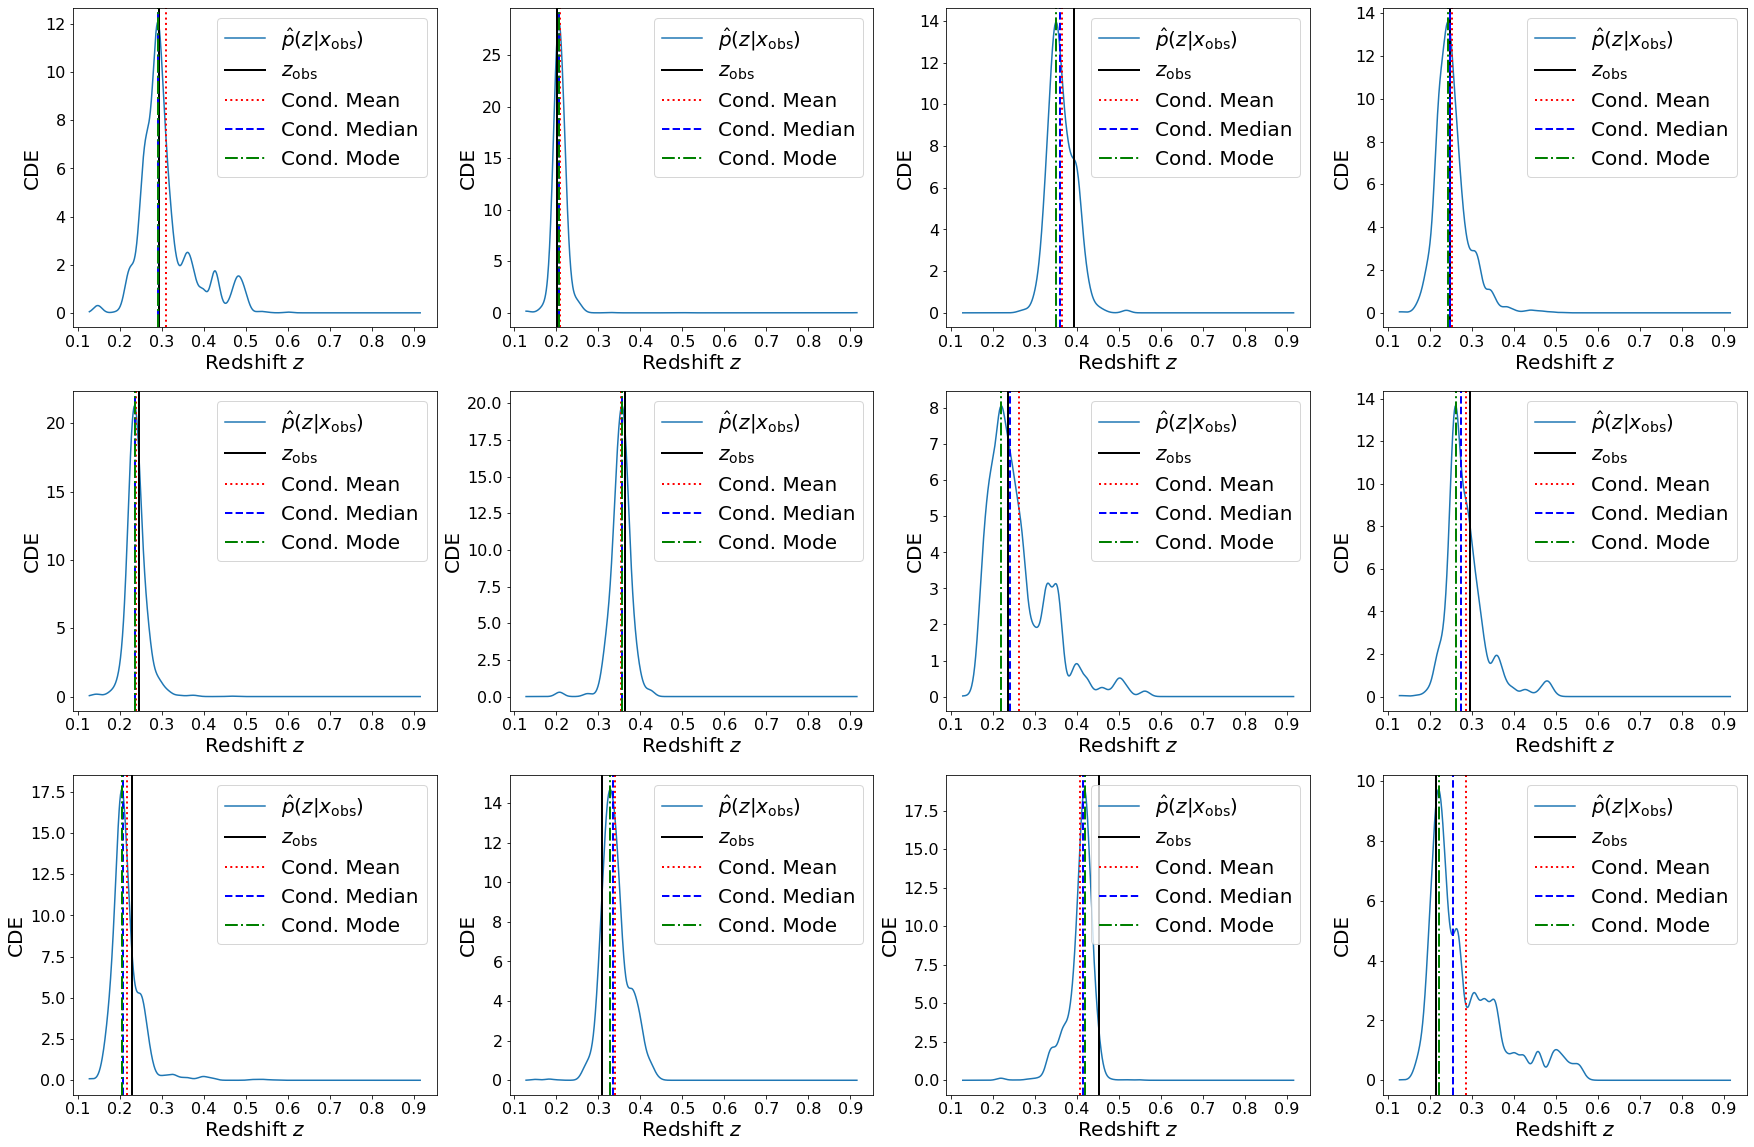

In [15]:
fig = plt.figure(figsize=(30, 20))
for jj, cde_predicted in enumerate(cde_test[:12,:]):
    ax = fig.add_subplot(3, 4, jj + 1)
    plt.plot(z_grid, cde_predicted, label=r'$\hat{p}(z| x_{\rm obs})$')
    plt.axvline(z_test[jj], color='black', label=r'$z_{\rm obs}$', linewidth=2)
    plt.axvline(cond_mean[jj], color='red', linestyle=':', linewidth=2, label='Cond. Mean')
    plt.axvline(cond_median[jj], color='blue', linestyle='--', linewidth=2, label='Cond. Median')
    plt.axvline(cond_mode[jj], color='green', linestyle='-.', linewidth=2, label='Cond. Mode')
    
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel(r'Redshift $z$', size=20)
    plt.ylabel('CDE', size=20)
    plt.legend(loc='upper right', prop={'size': 20})
    
plt.show()

One can also compute feature importances for random forest. <br>
This is usually calculated by looking at the proportion of times a tree has been splitted on a specific variable.

[21.28023134 13.6829653  26.66929548 22.97581493 15.39169295]


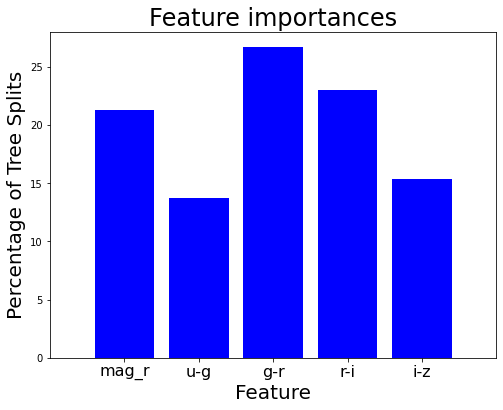

In [16]:
var_imp = model.variable_importance(type='count')
var_imp = (var_imp/sum(var_imp))*100
names_var = ['mag_r', 'u-g', 'g-r', 'r-i', 'i-z']
print(var_imp)

plt.figure(figsize=(8, 6))
plt.title("Feature importances", size=24)
plt.bar(range(5), var_imp, color="blue", align="center")
plt.xticks(range(5), names_var, size=16)
plt.xlabel('Feature', size=20)
plt.ylabel('Percentage of Tree Splits', size=20)
plt.xlim([-1, 5])
plt.show()

## Running fRFCDE

In order to run $\texttt{fRFCDE}$, the code is almost exactly the same as above, apart from the `train` call. <br>
For running $\texttt{fRFCDE}$ we include the Poisson process mean $\lambda$ in the `train` call in the `flambda` argument.

In [17]:
n_trees = 100
mtry = 4
node_size = 20
n_basis = 30
basis_system = 'cosine'

model_rfcde = rfcde.RFCDE(n_trees=n_trees, mtry=mtry, node_size=node_size, n_basis=n_basis, basis_system=basis_system)

In [18]:
model_rfcde.train(x_train, z_train, flambda=1)

In [19]:
n_grid = 1000
bandwidth = 0.01
z_grid = np.linspace(z_train.min(), z_train.max(), n_grid)
cde_test_rfcde = model_rfcde.predict(x_test, z_grid, bandwidth=bandwidth)

In [20]:
cde_loss_val, std_cde_loss = cde_loss(cde_test_rfcde, z_grid, z_test)
print('CDE Loss: %4.2f \pm %.2f' % (cde_loss_val, std_cde_loss))

CDE Loss: -12.47 \pm 0.51


## CDE Diagnostics

We can compute the PIT and HPD values over our estimated CDEs. <br>
Functions to calculate both values can be found in the [`cdetools` package](https://github.com/tpospisi/cdetools).
<br>
We suggest to clone the Github repository and install it.

<code style="background:black;color:white">git clone https://github.com/tpospisi/cdetools.git </code> <br>
<code style="background:black;color:white">cd cdetools/python/ </code> <br>
<code style="background:black;color:white">python setup.py install </code> 

In [24]:
from cdetools.hpd_coverage import hpd_coverage
from cdetools.cdf_coverage import cdf_coverage
from cdetools.plot_utils import plot_with_uniform_band

# Computing the values
z_grid = np.linspace(z_train.min(), z_train.max(), n_grid)
pit_values = cdf_coverage(cde_test, z_grid, z_test)
hpd_values = hpd_coverage(cde_test, z_grid, z_test)

Computing the number of values per each bin in the histogram under uniformity assumptions. <br>
We look at the 99% CI.

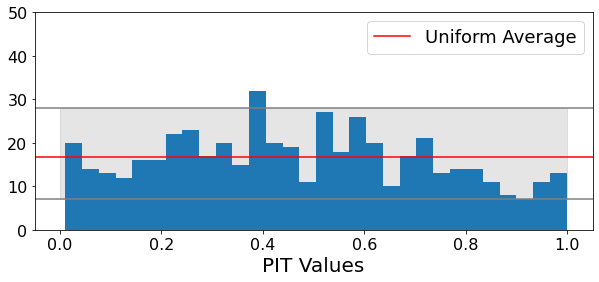

In [25]:
fig_pit = plot_with_uniform_band(values=pit_values, ci_level=0.99, x_label='PIT Values', n_bins=30)
fig_pit

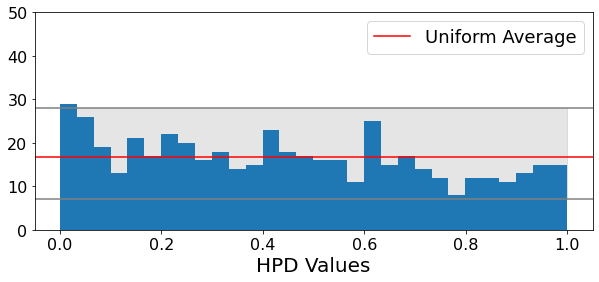

In [26]:
fig_hpd = plot_with_uniform_band(values=hpd_values, ci_level=0.99, x_label='HPD Values', n_bins=30)   
fig_hpd